# HyperCAT  Interferometry module

This notebook shows examples on how to use the interferometry module of HyperCAT. You will find here the general worksflow to obtain simulated interferomeric observations for a given AGN torus and uv plane defined byt he user.

In [1]:
# IMPORTS
import hypercat as hc
import interferometry as inter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ioops as io
from astropy.modeling import models


import ndiminterpolation

In [2]:
#For more information about to select subcubes and make a source check the hypercat_workflow.ipynb notebook.

# Load a sub-cube into RAM
hdf5file = '/Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20170714.hdf5'
cube = hc.ModelCube(hdffile=hdf5file,hypercube='imgdata',subcube_selection='../examples/Circinus.json')

INFO:root:Opening HDF5 file: /Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20170714.hdf5 


Opening HDF5 file: /Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20170714.hdf5 


INFO:root:Loading sampling parameters.


Loading sampling parameters.


INFO:root:Closing HDF5 file.


Closing HDF5 file.


INFO:root:Loading objects from file ../examples/Circinus.json.


Loading objects from file ../examples/Circinus.json.


INFO:root:Loading hyperslab [shape: (1,2,1,1,2,2,19,221,441)] from hypercube 'imgdata' [shape: (5,11,4,12,5,7,19,221,441)] to RAM (56.51 MB required) ...


Loading hyperslab [shape: (1,2,1,1,2,2,19,221,441)] from hypercube 'imgdata' [shape: (5,11,4,12,5,7,19,221,441)] to RAM (56.51 MB required) ...


INFO:root:Done.


Done.


INFO:root:Squeezing all dim-1 axes...


Squeezing all dim-1 axes...


INFO:root:Instantiating n-dim interpolation object ...


Instantiating n-dim interpolation object ...


INFO:root:Done.


Done.
Inspect loaded hypercube with .print_sampling()

Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
  sig      [ 45.000 -  45.000]  (  1)    45.000
    i *    [ 60.000 -  66.422]  (  2)    60.000, 66.422
    Y      [ 15.000 -  15.000]  (  1)    15.000
    N      [ 12.000 -  12.000]  (  1)    12.000
    q *    [  0.500 -   1.000]  (  2)     0.500,  1.000
   tv *    [ 40.000 -  60.000]  (  2)    40.000, 60.000
 wave *    [  1.200 - 870.000]  ( 19)     1.200,  2.200,  3.500,  4.800,  8.700,  9.300,  9.800, 10.000, 10.300, 10.600, 11.300, ...
    x      [  0.000 - 220.000]  (221)     0.000,  1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000,  9.000, 10.000, ...
    y      [  0.000 - 440.000]  (441)     0.000,  1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000,  9.000, 10.000, ...
-------------------------------------------------------
Parameters printed in bold and/or marked with an asterisk (*) are 

INFO:root:Rotated image (see self.data) by -37.0 deg in direction 'NE'.


Rotated image (see self.data) by -37.0 deg in direction 'NE'.


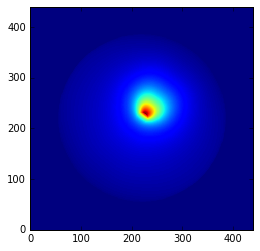

In [50]:
#Make a source
circinus = hc.Source(cube,luminosity='6e43 erg/s',distance='4.2 Mpc',name='Circinus',pa='-37 deg')  

#Select a clumpy torus image and wavelength. Assuming a flux density of 2500 mJy at 8.5 microns.
i = 61
q = 0.9
tauv = 54
wave = 12.
theta = (i,q,tauv,wave)
sky = circinus(theta)

plt.imshow(sky.data.T,origin='lower',interpolation='Nearest')

In [77]:
reload(inter)
mod = 'False'
#Create 2D FFT of clumpy torus image
ori_fft = inter.ima2fft(sky,abs=mod)
#Obtain pixel scale
fftscale = inter.fft_pxscale(sky)
#Obtain uv points
filename = '../examples/Circinus_clean.oifits' 
u,v = inter.uvload(filename)
#obtain baseline and position angles in 1D
BL, Phi = inter.baseline_phase_1D(u,v)
#Obtain uv plane in pixels
u_px,v_px = inter.uvfreq2uvpixel(u,v,fftscale)
#Obtain correlated flux 
corrflux, BL, Phi = inter.correlatedflux(ori_fft,u,v,abs=mod)
#obtain image fom fft
#ima_ifft

Pixel scale in FFT image is:  12.8306605574  m (Baseline) per pixel


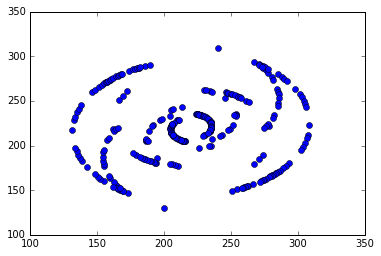

In [78]:
x  = np.arange(ori_fft.shape[0])
ip = ndiminterpolation.NdimInterpolation(ori_fft,[x,x])
uu = u + ori_fft.shape[0]/2
vv = v + ori_fft.shape[0]/2

#imagenew = ip((vv,uu))

#plt.imshow(imagenew)
plt.plot(uu,vv,'o')



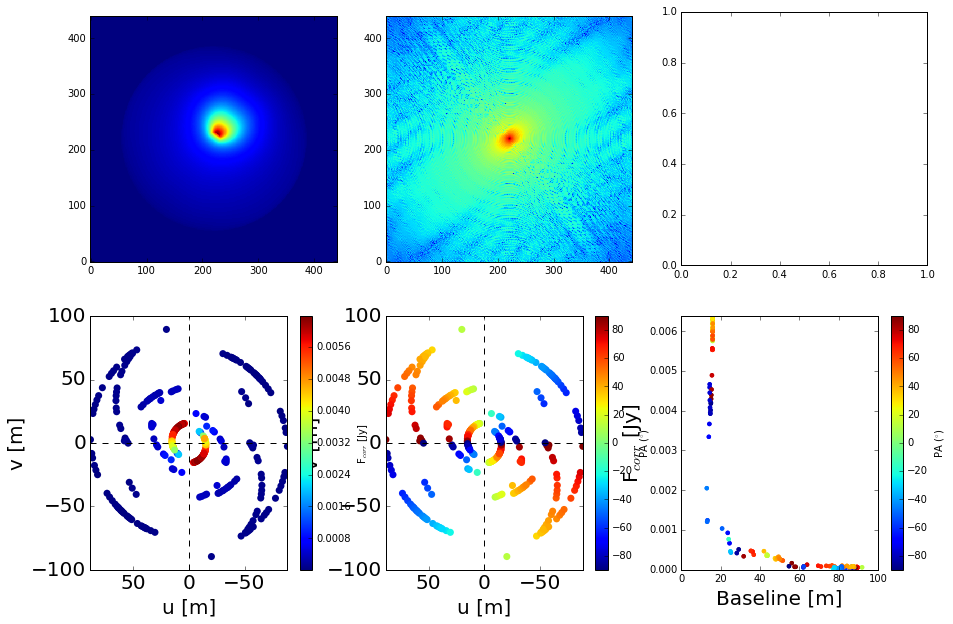

In [79]:
def plot_inter(ima,ima_fft,u,v,fftscale,corrflux,BL,Phi):
    fig1, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,10))
    
    #Sky image
    ax1.imshow(ima.data.T,origin='lower',interpolation='Nearest')
    
    #FFT Image
    ax2.imshow(np.log10(ima_fft),origin='lower',interpolation='Nearest')
    
    #iFFt image
    #ax3.imshow(ima_ifft,origin='lower',interpolation='Nearest')
    
    #uvplane and correlated flux
    cbar = ax4.scatter(u,v,c = corrflux,s=50,linewidths=0)
    plt.colorbar(cbar,label='F$_{corr}$ [Jy]',ax=ax4)
    ax4.tick_params(labelsize=20) 
    ax4.set_xlim([np.max(u),np.min(u)])
    ax4.set_ylabel('v [m]',fontsize=20)
    ax4.set_xlabel('u [m]',fontsize=20)
    ax4.axvline(0,linestyle='--',color='black')
    ax4.axhline(0,linestyle='--',color='black')
    
    #uvplane and Phi
    cbar = ax5.scatter(u,v,c = Phi,s=50,linewidths=0)
    plt.colorbar(cbar,label='PA ($^{\circ}$)',ax=ax5)
    ax5.tick_params(labelsize=20) 
    ax5.set_xlim([np.max(u),np.min(u)])
    ax5.set_ylabel('v [m]',fontsize=20)
    ax5.set_xlabel('u [m]',fontsize=20)
    ax5.axvline(0,linestyle='--',color='black')
    ax5.axhline(0,linestyle='--',color='black')

    #Correlated flux vs baseline
    cbar = ax6.scatter(BL,corrflux,c = Phi,s=20,linewidths=0)
    plt.colorbar(cbar,label='PA ($^{\circ}$)',ax=ax6)
    ax6.set_ylim([0,np.max(corrflux)])
    ax6.set_ylabel('F$_{corr}$ [Jy]',fontsize=20)
    ax6.set_xlabel('Baseline [m]',fontsize=20)

    
plot_inter(sky,np.abs(ori_fft),u,v,fftscale,corrflux,BL,Phi)    

In [30]:
#Check
#-- AxisGrid
#-- GridSpec

array([ 0.,  2.])

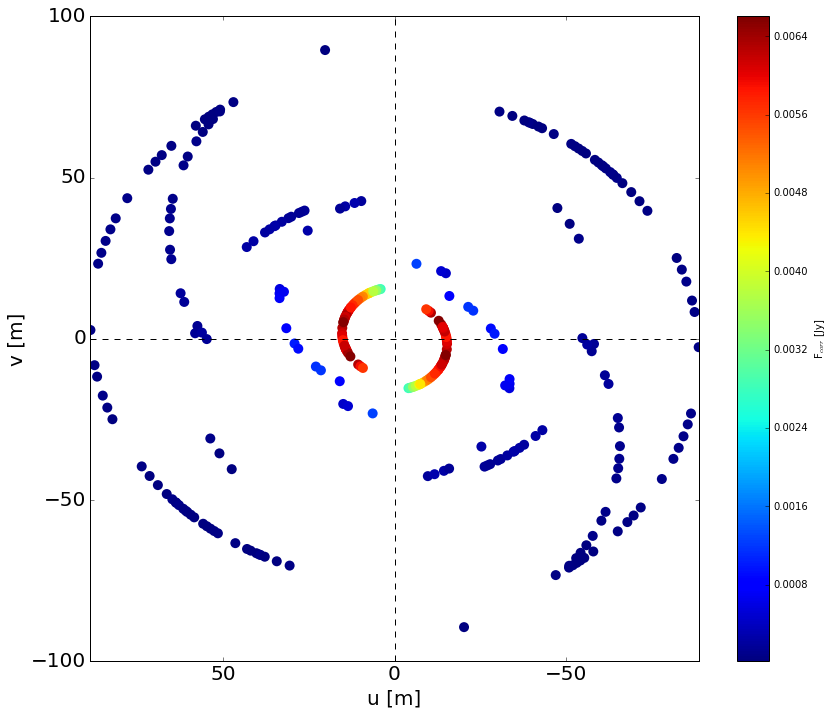

In [26]:
fig1, ax1 = plt.subplots(1,1,figsize=(12,10))
cbar = ax1.scatter(u,v,c = values,s=100,linewidths=0)
plt.colorbar(cbar,label='F$_{corr}$ [Jy]',ax=ax1)
ax1.tick_params(labelsize=20) 
ax1.set_xlim([np.max(u),np.min(u)])
ax1.set_ylabel('v [m]',fontsize=20)
ax1.set_xlabel('u [m]',fontsize=20)
ax1.axvline(0,linestyle='--',color='black')
ax1.axhline(0,linestyle='--',color='black')

fig1.tight_layout()

(0.058733669380754458, 0.99999988003277041)

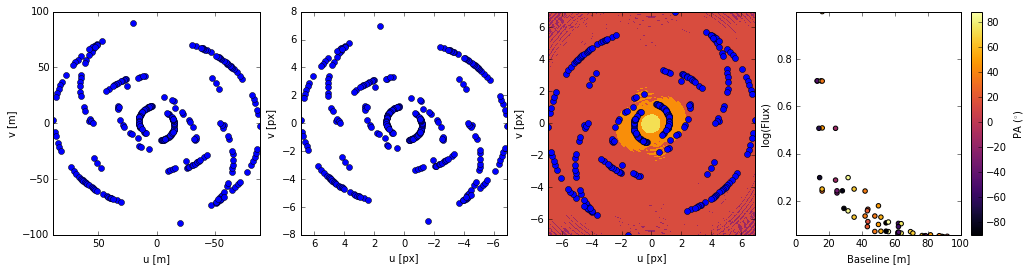

In [12]:
#Plots

ori_fft = np.abs(ori_fft)

fig1, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(17,4))

ax1.plot(u,v,'o')
ax1.set_xlabel('u [m]')
ax1.set_xlim([np.max(u),np.min(u)])
ax1.set_ylabel('v [m]')

ax2.plot(u_px,v_px,'o')
ax2.set_xlabel('u [px]')
ax2.set_xlim([np.max(u_px),np.min(u_px)])
ax2.set_ylabel('v [px]')

x = np.linspace(-ori_fft.shape[0]/2,ori_fft.shape[0]/2,ori_fft.shape[0])/fftscale

ax3.contourf(x,x,np.log10(ori_fft),5,cmap='inferno')
ax3.plot(u_px,v_px,'o')
ax3.set_xlabel('u [px]')
ax3.set_ylabel('v [px]')
ax3.set_ylim([np.min(v_px),np.max(v_px)])
ax3.set_xlim([np.min(u_px),np.max(u_px)])

BL = np.linspace(0,len(corrflux1D),len(corrflux1D))
n_good = np.where(corrflux2D > 0)
plot = ax4.scatter(BL2D[n_good], corrflux2D[n_good], c = Phi2D[n_good], cmap = 'inferno')
plt.colorbar(plot,label='PA ($^{\\circ}$)',ax=ax4)
#ax5.set_yscale('log')
ax4.set_ylabel('log(Flux)')
ax4.set_xlabel('Baseline [m]')
ax4.set_ylim([np.min(corrflux2D[n_good])*2,np.max(corrflux2D[n_good])])

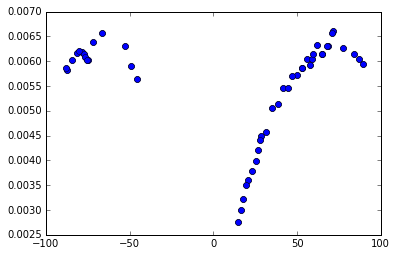

In [245]:
plt.plot(Phi[BL<20],values[BL<20],'o')

In [111]:
### Defining Gaussians
g1  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, x_stddev=1, y_stddev=0.16, theta=46)

g2  = models.Gaussian2D(amplitude=2, x_mean=0, y_mean=0, x_stddev=1, y_stddev=0.45, theta=107)

g3  = models.Gaussian2D(amplitude=1, x_mean=-0.5, y_mean=1, x_stddev=0.5, y_stddev=.5, theta=0)

xx = np.linspace(-10,10,100)
x,y = np.meshgrid(xx,xx)

ori = g1(x,y) + g2(x,y) + g3(x,y)
####

In [ ]:
#### Interferometry routines by HyperCAT

#Create 2D FFT of clumpy torus image
ori_fft = inter.ima2fft(ori)
#Obtain pixel scale
fftscale = inter.fft_pxscale(ori)
#Obtain uv points
filename = '../examples/Circinus_clean.oifits' 
u,v = inter.uvload(filename)
#obtain baseline and position angles in 1D
BL, Phi = inter.baseline_phase_1D(u,v)
#Obtain uv plane in pixels
u_px,v_px = inter.uvfreq2uvpixel(u,v,fftscale)
#Obtain correlated flux 2D
corrflux2D, BL2D, Phi2D = inter.correlatedflux2D(ori_fft,u_px,v_px,BL,Phi)
#Obtain correlated flux 1D
corrflux1D = inter.correlatedflux1D(corrflux2D)

In [ ]:
#Plots
fig1, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,6,figsize=(22,3))

ax0.imshow(ori,origin='lower',interpolation='Nearest')


ax1.plot(u,v,'o')
ax1.set_xlabel('u [m]')
ax1.set_xlim([np.max(u),np.min(u)])
ax1.set_ylabel('v [m]')

ax2.plot(u_px,v_px,'o')
ax2.set_xlabel('u [px]')
ax2.set_xlim([np.max(u_px),np.min(u_px)])
ax2.set_ylabel('v [px]')

x = np.linspace(-ori_fft.shape[0]/2,ori_fft.shape[0]/2,ori_fft.shape[0])

ax3.contourf(x,x,np.log10(ori_fft),31)
ax3.plot(u_px,v_px,'o')

ax4.imshow(corrflux2D,interpolation='Nearest',origin='lower',cmap='gray_r',vmin=0,vmax=0.0000001)

BL = np.linspace(0,len(corrflux1D),len(corrflux1D))
n_good = np.where(corrflux2D > 0)
plot = ax5.scatter(BL2D[n_good], corrflux2D[n_good], c = Phi2D[n_good], cmap = 'inferno')
plt.colorbar(plot,label='PA ($^{\\circ}$)',ax=ax5)
#ax5.set_yscale('log')
ax5.set_ylabel('log(Flux)')
ax5.set_xlabel('Baseline [m]')
ax5.set_ylim([np.min(corrflux2D[n_good])*2,np.max(corrflux2D[n_good])])

In [ ]:
import pylab as p
import numpy as N
import ndiminterpolation
import morphology

In [ ]:
G = morphology.gaussian(21,3,2)
x = N.arange(21.)
ip = ndiminterpolation.NdimInterpolation(G,[x,x])

In [ ]:
u = N.random.uniform(0,20,10000)
v = N.random.uniform(0,20,10000)
values = ip(N.dstack((u,v)))

In [ ]:
fig, ax = p.subplots(nrows=1,ncols=2,figsize=(8,4))
ax[0].imshow(G.T,origin='lower')
ax[0].set_ylabel('v')
ax[0].set_xlabel('u')
ax[0].scatter(u,v,s=0.2,c='w',linewidths=0)
ax[1].scatter(u,values,c='b',linewidths=0,s=0.4,label='u')
ax[1].scatter(v,values,c='r',linewidths=0,s=0.4,label='v')
ax[1].legend(frameon=0,markerscale=6)